In [1]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

# Get data

## Basemap

<Axes: >

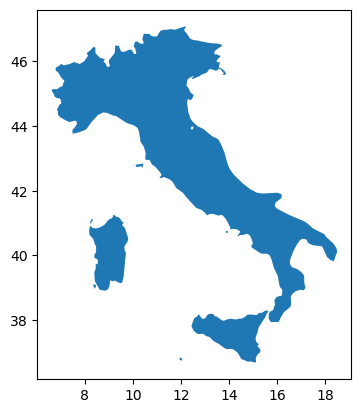

In [3]:
# Load map of Italy
world = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\ne_50m_admin_0_countries\\ne_50m_admin_0_countries.shp"))
italy = world[world["SOVEREIGNT"]=="Italy"]
italy.plot()

In [4]:
italy.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Gelaterias

In [5]:
# get gelaterias from OSM

#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Italia"][admin_level=2]->.searchArea;

(node["amenity"="ice_cream"](area.searchArea); 
way["amenity"="ice_cream"](area.searchArea);
rel["amenity"="ice_cream"](area.searchArea);
node["shop"="ice_cream"](area.searchArea); 
way["shop"="ice_cream"](area.searchArea);
rel["shop"="ice_cream"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [6]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "shop":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "shop", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [7]:
name_cat = []
gdf["name_clean"] = gdf["name"].str.lower().str.replace("&", "e")

for i,name in enumerate(gdf["name_clean"]):
    if "gelateria" in name:
        name_cat.append("Gelateria")
    elif ("gelato" in name) | ("gelati" in name) :
        name_cat.append("Gelato")
    else:
        name_cat.append("Other")

gdf["name_group"] = name_cat
gdf["name_group"].value_counts()

name_group
Other        2765
Gelateria    1522
Gelato        581
Name: count, dtype: int64

In [8]:
# top names
gdf["name_clean"].value_counts().to_frame().head(12)

,count
name_clean,
,546
gelateria,56
crema e cioccolato,53
grom,35
gelateria artigianale,20
la bottega del gelato,18
venchi,18
yogorino,17
la gelateria,16


# Visualise

In [9]:
from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [10]:
bg_color="#163555"
font_color="#eaeaea"
font_color_subtle = "#CECECE"
colrs = {"Gelateria": "#D9D66A", "Gelato": "#D89EA9", "Other":"#D89EA9" }
#colrs = {"Gelateria": "#8FD2DD", "Gelato": "#D89EA9", "Other":"#D9D66A" } # tested different colours

#set font styles
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inter-Medium.otf')
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\ArtYard Thick.ttf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inter-Thin.otf')

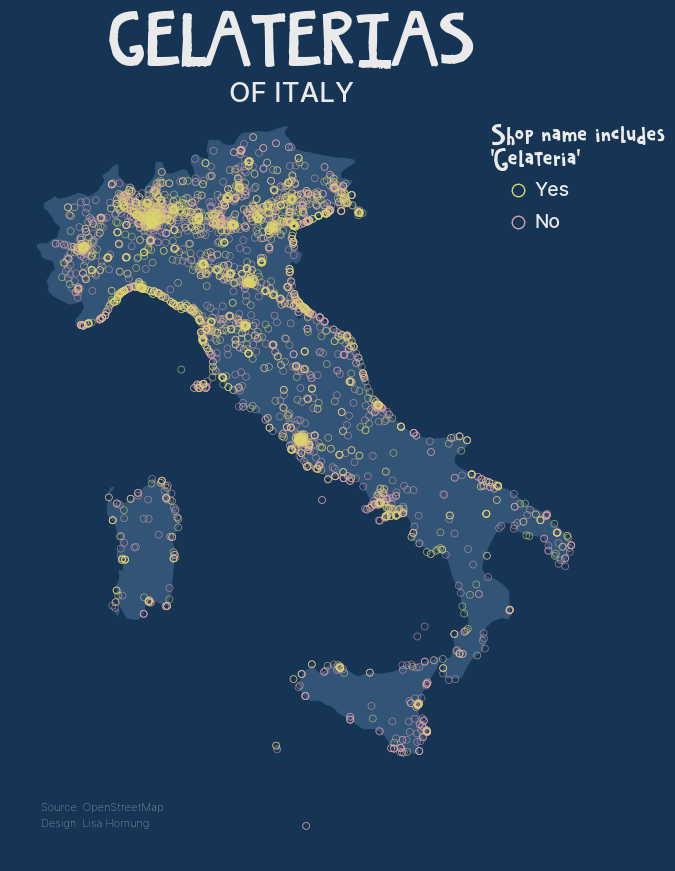

In [11]:
#plot
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor(bg_color)

# ===
# Data
italy.plot(ax=ax, alpha=1, zorder=1, color="#325477")

markers = {"Gelateria": "o", "Gelato": "o", "Other":"o" } # tested different marker shapes 
for group in ["Other",  "Gelato", "Gelateria",]:
    gdf_filtered = gdf[gdf["name_group"]==group]
    gdf_filtered.plot(ax=ax, zorder=3, markersize=25, edgecolor=colrs[group], marker=markers[group], linewidth=0.5, alpha=0.7, color="None")

ax.axis("off")

# === 
# Legend
lgd = fig.add_axes([0.68, 0.7, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=9, alpha=1, markerfacecolor="None")
legend_elements2 = [Line2D([0], [0], markeredgecolor=colrs["Gelateria"], label="Yes", **kw), 
                  Line2D([0], [0], markeredgecolor=colrs["Other"], label="No", **kw),]
L = lgd.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1, handletextpad=0.2,labelspacing=1)
plt.setp(L.texts,  va="baseline",color=font_color, fontproperties=subtitle_font,size=14, )    
lgd.text(0.15,0.82,"Shop name includes\n'Gelateria'",  va="baseline",color=font_color, fontproperties=title_font,size=12, )
lgd.axis("off")

#====
# Text
plt.figtext(0.5, 0.87 , "of Italy".upper(), fontproperties=subtitle_font, fontsize=20,  ha="center", color=font_color)
plt.figtext(0.5, 0.87+0.05, "Gelaterias".upper(), fontproperties=title_font, fontsize=30,  ha="center", color=font_color)
plt.figtext(0.25, 0.145, "Source: OpenStreetMap \nDesign: Lisa Hornung", fontproperties=label_font, fontsize=8, ha="left", color="#CECECE", linespacing=1.8)


#====
# export
#plt.savefig("gelaterias-italy.png", bbox_inches='tight', dpi=300, pad_inches=0.4, facecolor=bg_color)

plt.show()

In [12]:
gdf["name_clean"].value_counts().head(11)[1:]

name_clean
gelateria                56
crema e cioccolato       53
grom                     35
gelateria artigianale    20
la bottega del gelato    18
venchi                   18
yogorino                 17
la gelateria             16
la romana                15
il gelatiere             14
Name: count, dtype: int64

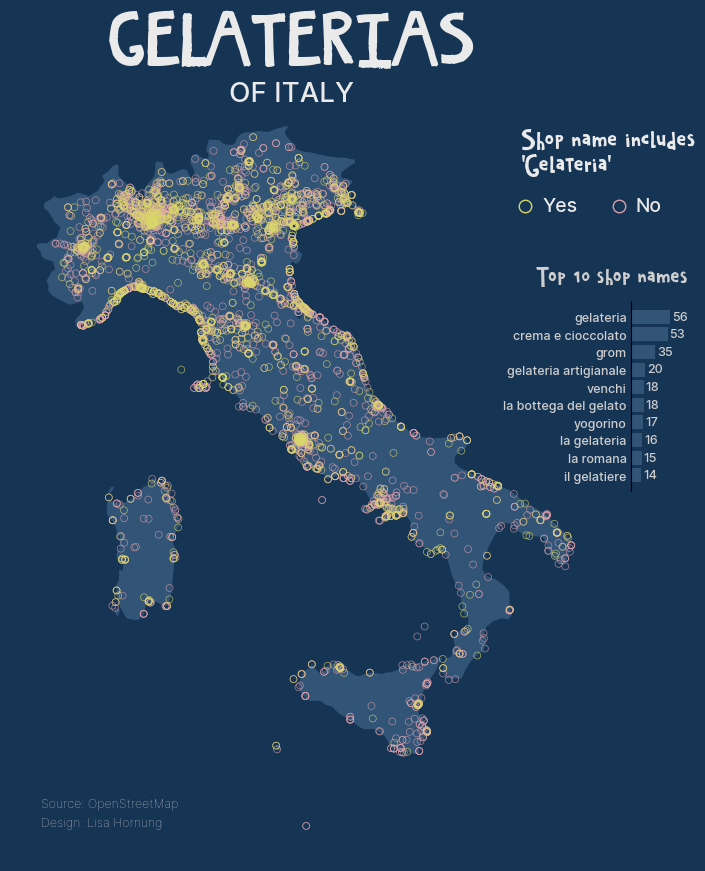

In [13]:
#plot
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor(bg_color)

# ===
# Data
italy.plot(ax=ax, alpha=1, zorder=1, color="#325477")

# points
markers = {"Gelateria": "o", "Gelato": "o", "Other":"o" } # tested different marker shapes 
for group in ["Other",  "Gelato", "Gelateria",]:
    gdf_filtered = gdf[gdf["name_group"]==group]
    gdf_filtered.plot(ax=ax, zorder=3, markersize=25, edgecolor=colrs[group], marker=markers[group], linewidth=0.5, alpha=0.75, color="None")

ax.axis("off")

# bar chart
labels = gdf["name_clean"].value_counts().head(11)[1:].sort_values().index
values = gdf["name_clean"].value_counts().head(11)[1:].sort_values().values
y_pos = np.arange(1,11,1)

baxes = fig.add_axes([0.84, 0.48, 0.04, 0.19]) #axes to hold bar chart
baxes.barh(y_pos, values, height=0.8, linewidth=0, color="#325477")
baxes.text(-140,len(y_pos)+2,"Top 10 shop names", fontsize=11, ha="left", fontproperties = title_font, color=font_color_subtle)
for i in range(len(values)):
    baxes.text(values[i]+3, y_pos[i] , values[i], va="center", fontsize=9, fontproperties = subtitle_font, color=font_color_subtle)

# format axis
baxes.tick_params(axis='y', length = 0, color = "#444444")
baxes.set_yticks(y_pos, labels, fontproperties=subtitle_font,size=9, color=font_color_subtle)
for pos in ["top", "bottom", "right"]:
    baxes.spines[pos].set_visible(False)
baxes.set_facecolor(bg_color)
baxes.xaxis.set_visible(False)


# === 
# Legend
lgd = fig.add_axes([0.73, 0.7, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=9, alpha=1, markerfacecolor="None")
legend_elements2 = [Line2D([0], [0], markeredgecolor=colrs["Gelateria"], label="Yes", **kw), 
                  Line2D([0], [0], markeredgecolor=colrs["Other"], label="No", **kw),]
L = lgd.legend(frameon=False, handles=legend_elements2, loc='center', ncol=2, handletextpad=0.2,labelspacing=1)
plt.setp(L.texts,  va="baseline",color=font_color, fontproperties=subtitle_font,size=14, )    
lgd.text(0.0,0.78,"Shop name includes\n'Gelateria'",  va="baseline",color=font_color, fontproperties=title_font,size=12, )
lgd.axis("off")

#====
# Text
plt.figtext(0.5, 0.87 , "of Italy".upper(), fontproperties=subtitle_font, fontsize=20,  ha="center", color=font_color)
plt.figtext(0.5, 0.87+0.05, "Gelaterias".upper(), fontproperties=title_font, fontsize=30,  ha="center", color=font_color)
plt.figtext(0.25, 0.145, "Source: OpenStreetMap \nDesign: Lisa Hornung", fontproperties=label_font, fontsize=9, ha="left", color="#CECECE", linespacing=1.8)

#====
# export
plt.savefig("gelaterias-italy-barchart.png", bbox_inches='tight', dpi=300, pad_inches=0.4, facecolor=bg_color)

plt.show()

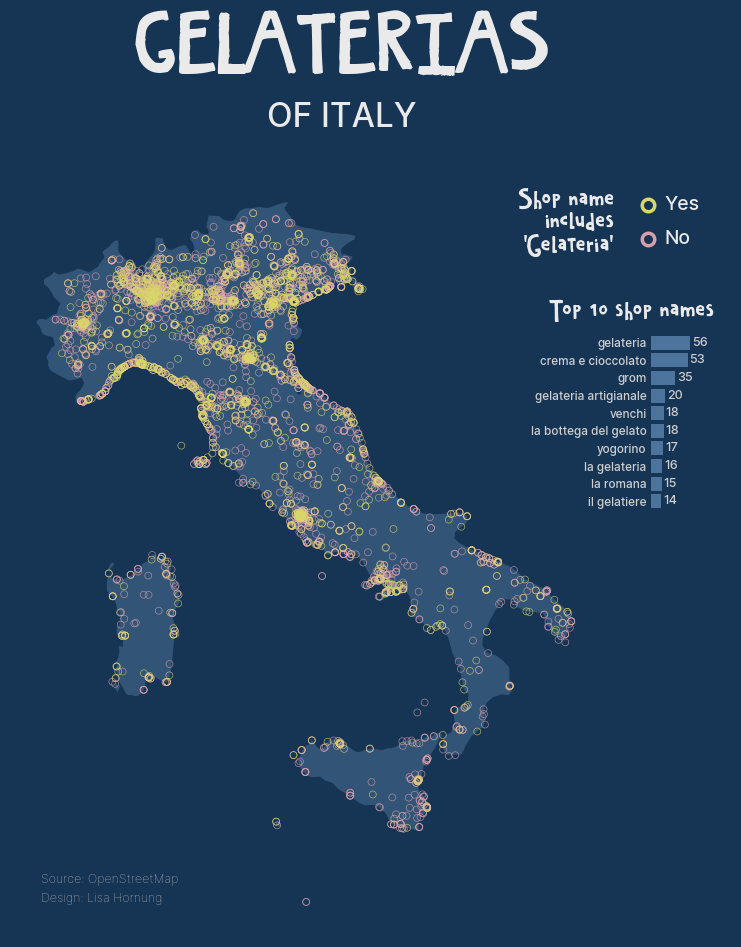

In [20]:
#plot
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor(bg_color)

# ===
# Data
italy.plot(ax=ax, alpha=1, zorder=1, color="#325477")

# points
markers = {"Gelateria": "o", "Gelato": "o", "Other":"o" } # tested different marker shapes 
for group in ["Other",  "Gelato", "Gelateria",]:
    gdf_filtered = gdf[gdf["name_group"]==group]
    gdf_filtered.plot(ax=ax, zorder=3, markersize=25, edgecolor=colrs[group], marker=markers[group], linewidth=0.5, alpha=0.75, color="None")

ax.axis("off")

# bar chart
labels = gdf["name_clean"].value_counts().head(11)[1:].sort_values().index
values = gdf["name_clean"].value_counts().head(11)[1:].sort_values().values
y_pos = np.arange(1,11,1)

baxes = fig.add_axes([0.86, 0.53, 0.04, 0.19]) #axes to hold bar chart
baxes.barh(y_pos, values, height=0.8, linewidth=0, color="#4D749C")
baxes.text(-150,len(y_pos)+1.5,"Top 10 shop names", fontsize=12, ha="left", fontproperties = title_font, color=font_color)
for i in range(len(values)):
    baxes.text(values[i]+3, y_pos[i] , values[i], va="center", fontsize=9, fontproperties = subtitle_font, color=font_color_subtle)

# format axis
baxes.tick_params(axis='y', length = 0, color = "#444444")
baxes.set_yticks(y_pos, labels, fontproperties=subtitle_font,size=8.5, color=font_color_subtle)
for pos in ["top", "bottom", "right", "left"]:
    baxes.spines[pos].set_visible(False)
baxes.set_facecolor(bg_color)
baxes.xaxis.set_visible(False)


# === 
# Legend
lgd = fig.add_axes([0.81, 0.76, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=9, alpha=1, markeredgewidth=2.5, markerfacecolor="None")
legend_elements2 = [Line2D([0], [0], markeredgecolor=colrs["Gelateria"], label="Yes", **kw), 
                  Line2D([0], [0], markeredgecolor=colrs["Other"], label="No", **kw),]
L = lgd.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1, handletextpad=0.2,labelspacing=1.2)
plt.setp(L.texts,  va="baseline",color=font_color, fontproperties=subtitle_font,size=14, )    
lgd.text(0.1,0.5,"Shop name\nincludes\n'Gelateria'",  va="center",ha="right",color=font_color, fontproperties=title_font,size=12, )
lgd.axis("off")

#====
# Text
plt.figtext(0.55, 0.92 , "of Italy".upper(), fontproperties=subtitle_font, fontsize=24,  ha="center", color=font_color)
plt.figtext(0.55, 0.92+0.07, "Gelaterias".upper(), fontproperties=title_font, fontsize=34,  ha="center", color=font_color)
plt.figtext(0.25, 0.145, "Source: OpenStreetMap \nDesign: Lisa Hornung", fontproperties=label_font, fontsize=9, ha="left", color="#CECECE", linespacing=1.8)

#====
# export
plt.savefig("gelaterias-italy-barchart.png", bbox_inches='tight', dpi=300, pad_inches=0.8, facecolor=bg_color)

plt.show()